In [3]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.externals import joblib
import pandas as pd
from __future__ import print_function
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS
from nltk.tag import pos_tag
from scipy.cluster.hierarchy import ward, dendrogram
import string
from gensim import corpora, models, similarities
import pickle

D:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
def read_data(folder_name):
    row_data = []
    target_label = []
    for f_outter in os.listdir(folder_name):
        outter_name = folder_name + "/" + f_outter
        for f_inner in os.listdir(outter_name):
            inner_name = outter_name + "/" + f_inner
            file_to_read = open(inner_name)
            text = file_to_read.read()
            row_data.append(text)
            target_label.append(f_outter)
    data = pd.DataFrame(
        {'text_data': row_data,
         'target_label': target_label})
    return data

In [5]:
if os.path.isfile('training_data.pkl'):
    train_data = pickle.load(open( "training_data.pkl", "rb"))
else:
    train_data = read_data('train')
    pickle.dump(train_data, open("training_data.pkl", "wb"))
train_data.head()

,text_data,target_label
0,From: mathew <mathew@mantis.co.uk>\nSubject: A...,alt.atheism
1,From: mathew <mathew@mantis.co.uk>\nSubject: A...,alt.atheism
2,From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...,alt.atheism
3,From: mathew <mathew@mantis.co.uk>\nSubject: R...,alt.atheism
4,From: strom@Watson.Ibm.Com (Rob Strom)\nSubjec...,alt.atheism


In [6]:
x_train = train_data['text_data']
y_train = train_data['target_label']

In [7]:
if os.path.isfile('testing_data.pkl'):
    test_data = pickle.load(open( "testing_data.pkl", "rb"))
else:
    test_data = read_data('test')
    pickle.dump(test_data, open("testing_data.pkl", "wb"))
test_data.head()

,text_data,target_label
0,From: decay@cbnewsj.cb.att.com (dean.kaflowitz...,alt.atheism
1,From: cfaehl@vesta.unm.edu (Chris Faehl)\nSubj...,alt.atheism
2,From: mathew <mathew@mantis.co.uk>\nSubject: R...,alt.atheism
3,"From: dps@nasa.kodak.com (Dan Schaertel,,,)\nS...",alt.atheism
4,From: halat@panther.bears (Jim Halat)\nSubject...,alt.atheism


In [8]:
x_test = test_data['text_data']
y_test = test_data['target_label']

In [9]:
x_train_parsed = []
for text in x_train:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    x_train_parsed.append(text)
x_train = x_train_parsed

In [10]:
x_test_parsed = []
for text in x_test:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    x_test_parsed.append(text)
x_test = x_test_parsed

In [19]:
import nltk
#nltk.download()

In [20]:
stemmer = SnowballStemmer("english")

In [21]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [22]:
totalvocab_stemmed = []
for i in x_train:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)

In [23]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(x_train)

print(tfidf_matrix.shape)

Wall time: 1min 25s
(11314, 24)


In [24]:
terms = tfidf_vectorizer.get_feature_names()
terms[:10]

["'m",
 "'s",
 'ani',
 'articl',
 'distribut',
 'doe',
 'good',
 'just',
 'know',
 'like']

In [ ]:
#dist = 1 - cosine_similarity(tfidf_matrix)

In [25]:
num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 15.2 s


In [ ]:
# t-SNE plot
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.show()

In [32]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)


range_n_clusters = [19,20,21,22,23,24,25,26,27,28,29,30]

for n_clusters in range_n_clusters:
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(tfidf_matrix)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    

Automatically created module for IPython interactive environment
For n_clusters = 19 The average silhouette_score is : 0.106299921602
For n_clusters = 20 The average silhouette_score is : 0.101797934044
For n_clusters = 21 The average silhouette_score is : 0.103773407505
For n_clusters = 22 The average silhouette_score is : 0.107859372625
For n_clusters = 23 The average silhouette_score is : 0.108079067139
For n_clusters = 24 The average silhouette_score is : 0.0881182930349
For n_clusters = 25 The average silhouette_score is : 0.100121606459
For n_clusters = 26 The average silhouette_score is : 0.0975853421831
For n_clusters = 27 The average silhouette_score is : 0.0873756018092
For n_clusters = 28 The average silhouette_score is : 0.0872380759657
For n_clusters = 29 The average silhouette_score is : 0.0867299060104
For n_clusters = 30 The average silhouette_score is : 0.0851667753772


Wall time: 0 ns


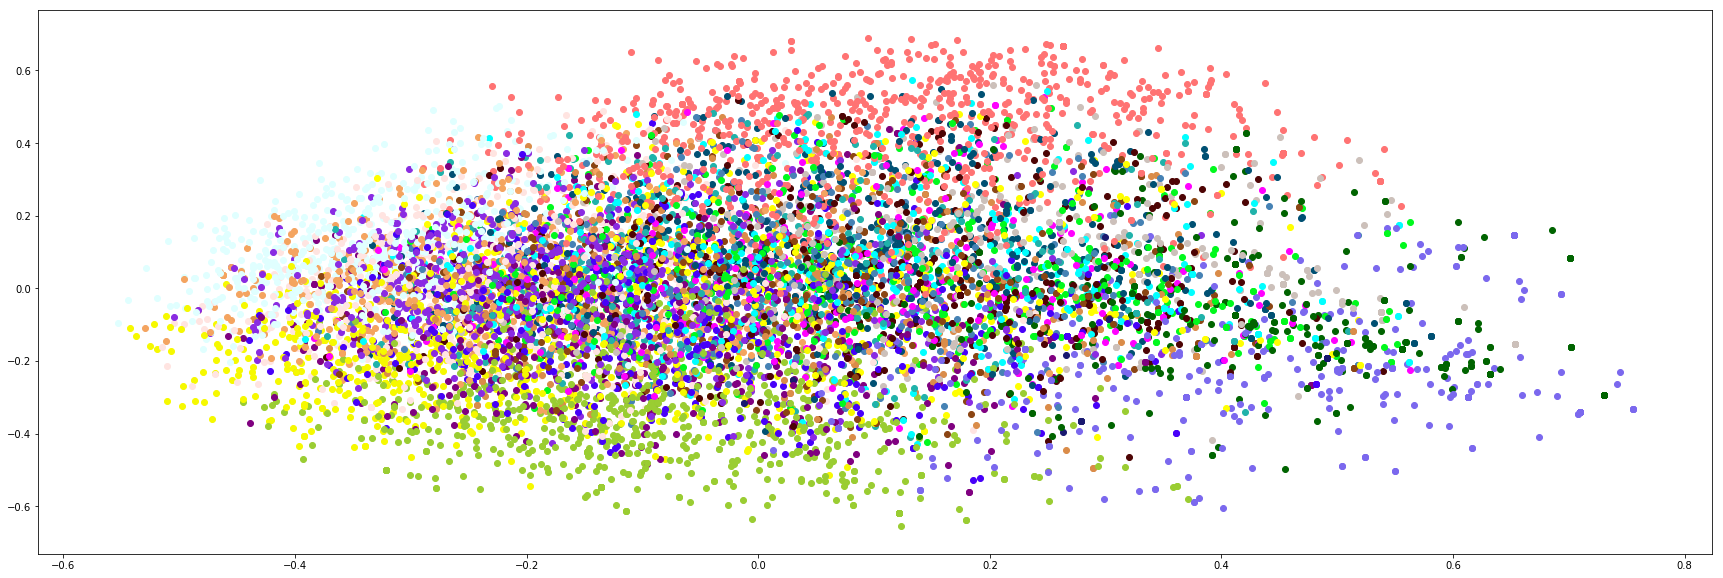

In [36]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


#For n_clusters = 23 The average silhouette_score is : 0.108079067139 is the max value :D 
num_clusters = 23
num_seeds = 10
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49',
    10: '#FFFF00', 11: '#9ACD32', 12: '#006400', 13: '#00FFFF', 14: '#E0FFFF',
    15: '#4682B4', 16: '#191970', 17: '#8A2BE2', 18: '#7B68EE',19: '#800080',
    20: '#FF00FF', 21: '#8B4513', 22: '#F4A460'
}
pca_num_components = 2
tsne_num_components = 2

# texts_list = some array of strings for which TF-IDF is being computed

# calculate tf-idf of texts
#tf_idf_vectorizer = TfidfVectorizer(analyzer="word", use_idf=True, smooth_idf=True, ngram_range=(2, 3))
#tf_idf_matrix = tf_idf_vectorizer.fit_transform(texts_list)

# create k-means model with custom config
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
    precompute_distances="auto",
    n_jobs=-1
)

labels = clustering_model.fit_predict(tfidf_matrix)
# print labels

X = tfidf_matrix.todense()

# ----------------------------------------------------------------------------------------------------------------------

reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
# print reduced_data

fig, ax = plt.subplots(figsize=(30,10))
for index, instance in enumerate(reduced_data):
    # print instance, index, labels[index]
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
%time enumerate(reduced_data)
plt.show()